#### Projet Fouille de texte : Classification thématique de chapôs du Monde 

> Ji AN

Ce script a pour but principal de reconstruire des données brutes, de les nettoyer et de les restocker dans des formats plus lisibles et plus adapté à la tâche.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import xml.etree.ElementTree as ET
plt.style.use('ggplot')

In [26]:
# GET FILE PATHS & STORE IN A LIST
def get_file_list(PathTail, category):
    paths = sorted(Path('/Users/ko/Desktop/pluriTAL_S2/03_2_ppe2/Corpus/2022').glob(PathTail))
    files = [str(f) for f in paths if f.is_file()]
    return files

# all metadata files of political news named as 0,57-0,64-823353,0.xml 
# and those of cinema news as 0,2-3476,1-0,0.xml
# the '01' in the paths mean the 1st day of each month
# but not all news are published on this day, some are published before or after
poli = get_file_list('*/01/*/0,57-0,64-823353,0.xml','POLITIQUE')
cine = get_file_list('*/01/*/0,2-3476,1-0,0.xml','CINEMA')
print('Total POLITIQUE files:', len(poli))
print('Total CINEMA files:', len(cine))

Total POLITIQUE files: 12
Total CINEMA files: 12


In [27]:
# GET DESCRIPTION, DATE, TITLE IN EACH OF THE 12 FILES OF EACH CATEGORY

def get_desc_list(FileList):
    # set empty list to store [title, date, description] later
    DescList = []
    # loop over each file 
    for file in FileList:
        tree = ET.parse(file)
        root = tree.getroot()
        # get all <item> elements & find their children : 
        # <title>, <pubDate>, <description>
        for item in root.iter('item'):
            pubDate = item.find('pubDate').text
            title = item.find('title').text
            desc = item.find('description').text
            # normalize date format
            date_object = datetime.strptime(pubDate, '%a, %d %b %Y %H:%M:%S %z')
            date = date_object.strftime('%Y-%m-%d %H:%M:%S %z')
            # append [title, date, desc] to DescList
            DescList.append([desc, date, title])
    return DescList   

DescPoli = get_desc_list(poli)
DescCine = get_desc_list(cine)
print(DescPoli[0], '\n\n', DescCine[0])
                

['Le tribunal administratif a rejeté le principal dispositif imaginé par la Mairie pour que ses agents travaillent moins de trente-cinq\xa0heures par semaine. La décision est définitive.', '2022-04-01 16:50:53 +0200', 'Anne Hidalgo perd son combat sur le temps de travail à Paris'] 

 ['L’actrice française, qui pratique aussi le dessin et la peinture, est exposée à partir du 2\xa0avril à la chapelle du Méjan, à Arles, et fait l’objet d’une monographie, dont certains textes sont signés du commissaire d’exposition Louis Deledicq. Le même qu’Anouk Grinberg a photographié il y a quinze ans.', '2022-04-01 18:00:07 +0200', 'Anouk Grinberg, comédienne\xa0: «\xa0Louis Deledicq m’a dit des choses sur la pulsion de peindre qui sont devenues fondatrices\xa0»']


In [28]:
# CREATE DATAFRAME & DROP ROWS WITH NaN VALUES
def get_real_desc(DescList, category):
    # create df with 2 DescList built above
    desc = pd.DataFrame(DescList, columns=['description','date','title']).sort_values('date')
    # add & fill category column at the beginning
    desc.insert(0, 'category', category) 
    # drop rows with NaN values
    desc = desc.dropna().reset_index(drop=True)
    return desc

# WRITE DESCRIPTIONS TO CSV
def save_desc_csv(desc, category):
    desc.to_csv(category+'.csv', index=False, header=True, encoding='utf-8')


RealPoli = get_real_desc(DescPoli, 'POLITIQUE')
RealCine = get_real_desc(DescCine, 'CINEMA')

print(
    RealPoli.head(3),
    '\n\n==================\n\n',
    RealCine.head(3)
    )

# save_desc_csv(RealPoli, 'POLITIQUE')
# save_desc_csv(RealCine, 'CINEMA')

    category                                        description  \
0  POLITIQUE  L’équipe de campagne du candidat à la présiden...   
1  POLITIQUE  Le ministre de l’économie, piqué de littératur...   
2  POLITIQUE  La République en marche avait déjà annoncé son...   

                        date  \
0  2021-12-30 12:00:13 +0100   
1  2021-12-30 12:06:27 +0100   
2  2021-12-30 20:08:58 +0100   

                                               title  
0  Eric Zemmour, du mépris des femmes à la hantis...  
1  Grâce à Michel Houellebecq, l’autre rentrée de...  
2  Présidentielle 2022 : Valérie Pécresse veut ap...   


   category                                        description  \
0   CINEMA  La jeune réalisatrice chinoise Xinyuan Zheng L...   
1   CINEMA  D’une drôlerie explosive, le nouveau film du r...   
2   CINEMA  Aucune nouvelle date n’a été fixée pour les Go...   

                        date  \
0  2021-12-22 09:00:03 +0100   
1  2021-12-22 10:00:15 +0100   
2  2021-12-22 22:43:2

In [37]:
# GET LENGTH INFOS OF DESCRIPTION FOR 2 CATEGORIES
def desc_info(RealDF, category):
    # get length of each description
    desc_len = RealDF.description.str.len()
    desc_words = RealDF.description.str.split().str.len()
    # get mean, median, max, min
    mean = desc_len.mean()
    median = desc_len.median()
    maxi = desc_len.max()
    mini = desc_len.min()
    # print infos
    print(
        category,
        '\nTotal observations: {}'.format(len(RealDF)),
        '\nNb. characters: {}'.format(desc_len.sum()),
        '\nNb. words: {}'.format(desc_words.sum()),
        '\nAvg. Nb. of words per description: {}'.format(desc_words.mean()),
        '\nMean length of descriptions: {}'.format(mean),
        '\nMedian length of descriptions: {}'.format(median),
        '\nMax length of descriptions: {}'.format(maxi),
        '\nMin length of descriptions: {}\n'.format(mini)
        )

desc_info(RealPoli, 'POLITIQUE')
desc_info(RealCine, 'CINEMA')

POLITIQUE 
Total observations: 238 
Nb. characters: 47903 
Nb. words: 7672 
Avg. Nb. of words per description: 32.23529411764706 
Mean length of descriptions: 201.2731092436975 
Median length of descriptions: 195.0 
Max length of descriptions: 373 
Min length of descriptions: 85

CINEMA 
Total observations: 240 
Nb. characters: 39992 
Nb. words: 6564 
Avg. Nb. of words per description: 27.35 
Mean length of descriptions: 166.63333333333333 
Median length of descriptions: 153.0 
Max length of descriptions: 399 
Min length of descriptions: 63



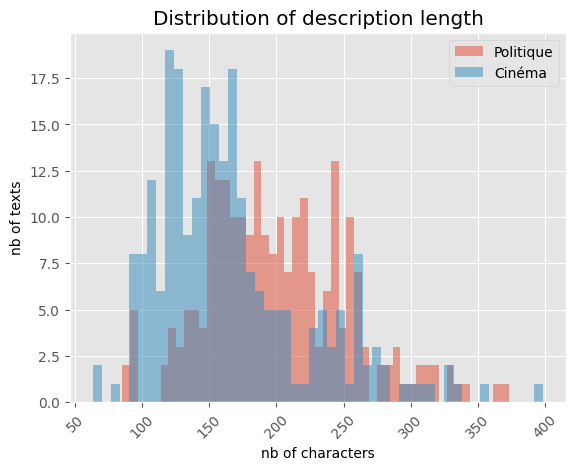

In [30]:
# PLOT HISTOGRAMS OF DESCRIPTION LENGTH
def plot_hist(df1, df2):
    df1.description.str.len().plot(kind='hist', bins=50, alpha=0.5, label='Politique',rot=45)
    df2.description.str.len().plot(kind='hist', bins=50, alpha=0.5, label='Cinéma',rot=45)
    plt.title('Distribution of description length')
    plt.xlabel('nb of characters')
    plt.ylabel('nb of texts')
    plt.legend()
    plt.show()

plot_hist(RealPoli, RealCine)


In [ ]:
# CREATE 2 DIRECTORIES FOR 2 CATEGORIES
def create_dir(cat1, cat2):
    P1 = Path(cat1).mkdir(parents=True, exist_ok=True)
    P2 = Path(cat2).mkdir(parents=True, exist_ok=True)

cat1 = 'Corpus/cinema'
cat2 = 'Corpus/politqiue'
create_dir(cat1, cat2)

In [ ]:
# STORE DESCRIPTIONS IN TXT FILES, ONE TXT FOR ONE DESCRIPTION
def save_desc_txt(df1, cat1, df2, cat2):
    for i in range(len(df1)):
        with open(cat1+'/'+str(i+1)+'.txt', 'w', encoding='utf-8') as f:
            f.write(df1.description.iloc[i])
    for i in range(len(df2)):
        with open(cat2+'/'+str(i+1+len(df1))+'.txt', 'w', encoding='utf-8') as f:
            f.write(df2.description.iloc[i])

save_desc_txt(RealCine, cat1, RealPoli, cat2)